In [1]:
import sys
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

sys.path.append('../src')
from topic_modeling import *

In [2]:
def visualisation(level_names, score_names, model_scores, figsize=(10, 10)):
    
    num_levels = len(level_names)
    num_scores = len(score_names)
    
    fig, axis = plt.subplots(num_scores, num_levels, sharey=True, figsize=figsize)
    
    for model_name, scores in model_scores.items():
        for i, score in enumerate(scores.values()):
            for j, level_score in enumerate(score):
                axis[i][j].plot(level_score, label=model_name)
    
    for i, score_name in enumerate(score_names):
        for j, level_name in enumerate(level_names):
            axis[i][j].set_title(f'{score_name} ({level_name})')
            axis[i][j].legend()
    
    plt.show()

In [3]:
dictionary = artm.Dictionary(dictionary_path='../data/interim/X_dictionary.dict')

with open(f'../data/interim/X', 'rb') as fl:
    X = pkl.load(fl)

with open(f'../data/interim/y_level_0', 'rb') as fl:
    y_level_0 = pkl.load(fl)
    
topic_names_level_0 = y_level_0.unique().tolist()
    
with open(f'../data/interim/y_level_1', 'rb') as fl:
    y_level_1 = pkl.load(fl)
    
topic_names_level_1 = y_level_1.unique().tolist()

y = pd.concat([y_level_0, y_level_1], axis=1)

level_names = y.columns

parent_topics_proportion = {}

for topic_name, parent_topics in y.groupby('hr_level_1')['hr_level_0'].unique().iteritems():
    parent_topic_proportion = np.zeros(len(topic_names_level_0))
    parent_topic_proportion[[topic_names_level_0.index(parent_topic_name) for parent_topic_name in parent_topics]] = 1
    
    parent_topics_proportion[topic_name] = parent_topic_proportion.tolist()

class_ids=['title_pers', 'title_orgs', 'title_locs', 'title_tokens', 'text_pers', 'text_orgs', 'text_locs', 'text_tokens']
default_class_ids = dict(zip(class_ids, len(class_ids)*[1.0]))

kfold = KFoldTM(random_state=42)

In [4]:
model_scores = dict()

model_scores['only level 0'] = kfold.validation(X, 
                                                y.drop('hr_level_1', axis=1), 
                                                {'accuracy':accuracy_score, 'f1_score':lambda x, y: f1_score(x, y, average='weighted')}, 
                                                class_ids=default_class_ids, 
                                                level_names=[level_names[0]], 
                                                topic_names=[topic_names_level_0])

model_scores['only level 1'] = kfold.validation(X, 
                                                y.drop('hr_level_0', axis=1), 
                                                {'accuracy':accuracy_score, 'f1_score':lambda x, y: f1_score(x, y, average='weighted')}, 
                                                class_ids=default_class_ids, 
                                                level_names=[level_names[1]], 
                                                topic_names=[topic_names_level_1])

model_scores = {'isolated levels': {name: np.concatenate([model_scores['only level 0'][name], model_scores['only level 1'][name]]) for name in ['accuracy', 'f1_score']}}

In [5]:
model_scores['hierarchy'] = kfold.validation(X, 
                                             y, 
                                             {'accuracy':accuracy_score, 'f1_score':lambda x, y: f1_score(x, y, average='weighted')}, 
                                             class_ids=default_class_ids, 
                                             level_names=level_names, 
                                             topic_names=[topic_names_level_0, topic_names_level_1])

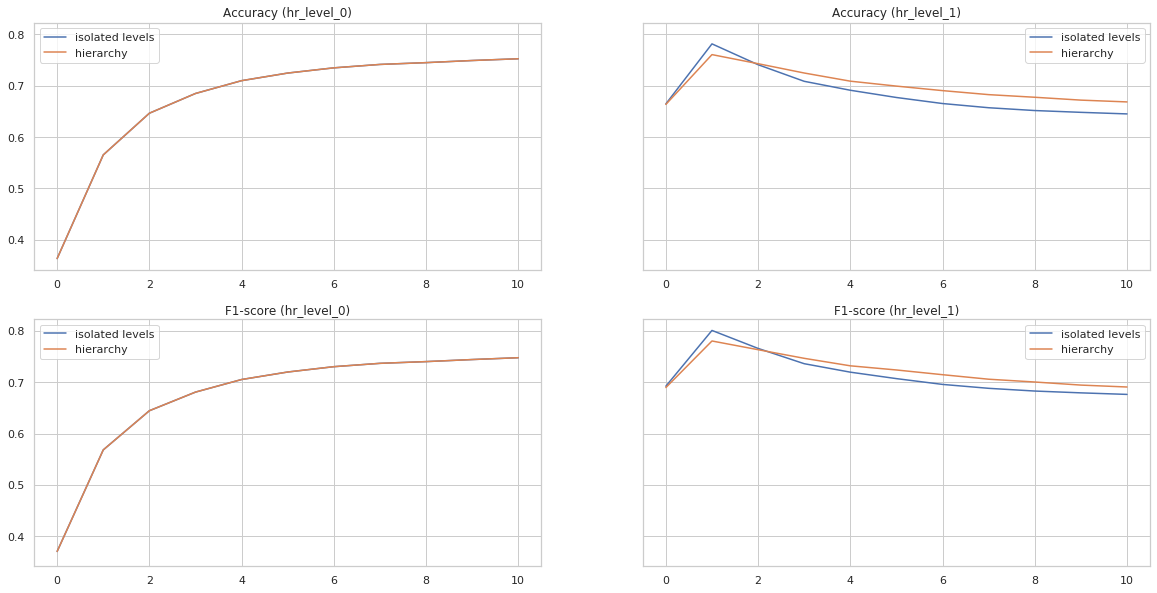

In [6]:
visualisation(level_names, ['Accuracy', 'F1-score'], model_scores, figsize=(20, 10))

In [14]:
model_scores = dict()
for spars_psi_tau in [0, 1.0, 10.0]:
    
    name = f'sparse phi {spars_psi_tau}'
    model_scores[name] = kfold.validation(X, 
                                          y, 
                                          {'accuracy':accuracy_score, 'f1_score':lambda x, y: f1_score(x, y, average='weighted')}, 
                                          class_ids=default_class_ids,
                                          level_names=level_names, 
                                          topic_names=[topic_names_level_0, topic_names_level_1],
                                          parent_topics_proportion=[parent_topics_proportion],
                                          spars_psi_tau=spars_psi_tau)

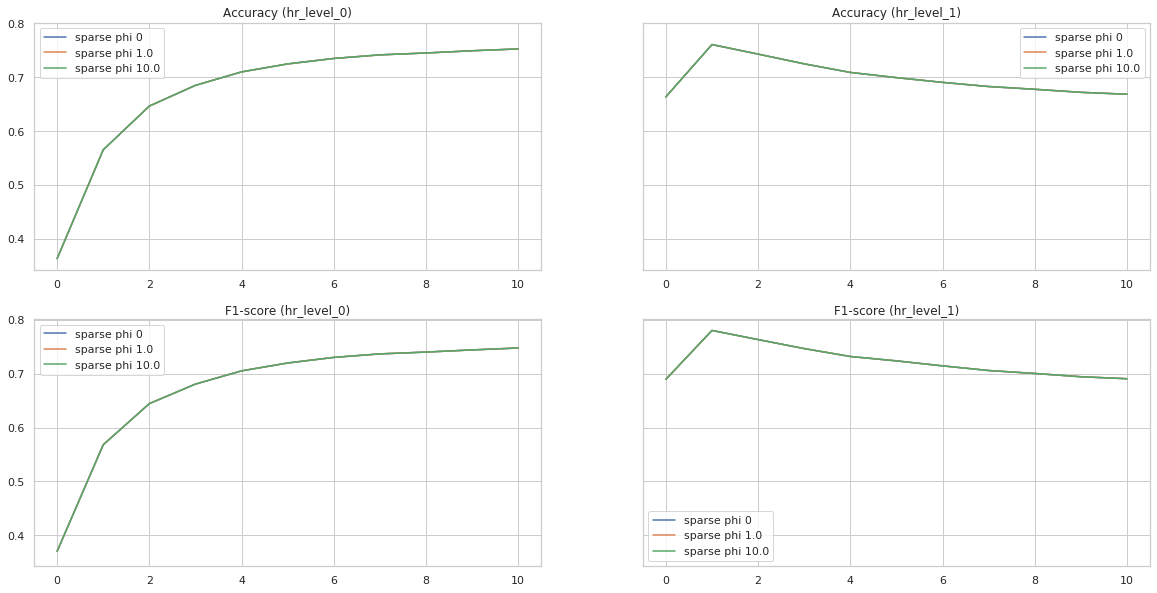

In [15]:
visualisation(level_names, ['Accuracy', 'F1-score'], model_scores, figsize=(20, 10), )

In [4]:
with open('X.txt', 'w') as fl:
    fl.write('\n'.join(X.index + ' ' + X.values)+'\n')
    
X = artm.BatchVectorizer(data_path='X.txt', data_format='vowpal_wabbit', target_folder='X_batches')

In [5]:
hierarchy_0 = TopicModel(dictionary, default_class_ids, level_names=level_names, topic_names=[topic_names_level_0, topic_names_level_1], num_collection_passes=10)
hierarchy_0.fit(X, y)

hierarchy_0.model[1].get_psi()

,Авто,Спорт,Политика,Происшествия,Общество,Культура,Технологии,Экономика,Наука
Авто,0.033235,0.032248,0.032514,0.031605,0.032992,0.031839,0.031187,0.031566,0.033899
Автоспорт,0.014782,0.015577,0.014479,0.014954,0.014718,0.014928,0.014557,0.015666,0.015389
Футбол,0.064337,0.069097,0.069190,0.069292,0.071483,0.068677,0.068524,0.070195,0.068849
Политика,0.025005,0.023168,0.022962,0.025422,0.024047,0.025522,0.024504,0.022898,0.024025
Спорт,0.021051,0.021070,0.021560,0.020367,0.021908,0.020917,0.023136,0.022642,0.022263
Происшествия,0.062874,0.060414,0.061674,0.063736,0.060463,0.061179,0.062210,0.060909,0.059370
Армия и оружие,0.054210,0.055268,0.055891,0.055414,0.053618,0.053831,0.053435,0.053874,0.055101
Общество,0.027534,0.027255,0.025204,0.029235,0.027425,0.027162,0.027259,0.025203,0.027441
Транспорт,0.031160,0.030563,0.031226,0.029873,0.029655,0.031706,0.032077,0.031010,0.032169
Культура,0.027381,0.027769,0.027994,0.026647,0.027966,0.028760,0.027848,0.028163,0.028595


In [6]:
hierarchy_1 = TopicModel(dictionary, default_class_ids, level_names=level_names, topic_names=[topic_names_level_0, topic_names_level_1], 
                         parent_topics_proportion=[parent_topics_proportion], num_collection_passes=10)
hierarchy_1.fit(X, y)

hierarchy_1.model[1].get_psi()

,Авто,Спорт,Политика,Происшествия,Общество,Культура,Технологии,Экономика,Наука
Авто,0.147403,0.013810,0.025637,0.027974,0.016851,0.019063,0.019997,0.020292,0.026540
Автоспорт,0.013039,0.064804,0.011276,0.013154,0.007491,0.008929,0.009266,0.010076,0.012088
Футбол,0.056889,0.087308,0.054857,0.061336,0.036690,0.040741,0.044838,0.046118,0.054569
Политика,0.022142,0.008747,0.127052,0.022303,0.011865,0.014665,0.015174,0.014463,0.019024
Спорт,0.018599,0.067286,0.016962,0.017992,0.011164,0.011897,0.015044,0.014689,0.017590
Происшествия,0.055671,0.025144,0.048545,0.176789,0.030106,0.036296,0.040300,0.038855,0.046719
Армия и оружие,0.047751,0.023268,0.153139,0.048899,0.026540,0.031695,0.034610,0.032900,0.043087
Общество,0.024285,0.011510,0.019848,0.025709,0.084680,0.016076,0.017534,0.015567,0.021520
Транспорт,0.027469,0.012933,0.024521,0.025803,0.085082,0.018980,0.020559,0.020232,0.025414
Культура,0.024163,0.011701,0.022111,0.023557,0.014271,0.097932,0.017915,0.018333,0.022432


In [7]:
np.abs(hierarchy_0.model[1].get_psi() - hierarchy_1.model[1].get_psi()).max().max()

0.11416787

In [8]:
np.abs(hierarchy_0.model[0].get_phi() - hierarchy_1.model[0].get_phi()).max().max()

1.8253922e-07

In [9]:
np.abs(hierarchy_0.model[1].get_phi() - hierarchy_1.model[1].get_phi()).max().max()

0.00789407

In [10]:
np.abs(hierarchy_0.model[0].get_theta() - hierarchy_1.model[0].get_theta()).max().max()

3.1888485e-06

In [11]:
np.abs(hierarchy_0.model[1].get_theta() - hierarchy_1.model[1].get_theta()).max().max()

0.027051121

In [12]:
hierarchy_1 = TopicModel(dictionary, default_class_ids, level_names=level_names, topic_names=[topic_names_level_0, topic_names_level_1], 
                         parent_topics_proportion=[parent_topics_proportion], num_collection_passes=10, spars_psi_tau=10)
hierarchy_1.fit(X, y)

hierarchy_1.model[1].get_psi()

,Авто,Спорт,Политика,Происшествия,Общество,Культура,Технологии,Экономика,Наука
Авто,0.581549,0.002227,0.008933,0.013921,0.003109,0.004144,0.004858,0.004932,0.009288
Автоспорт,0.006411,0.094428,0.003874,0.006459,0.001381,0.001916,0.002217,0.002416,0.004199
Футбол,0.028046,0.098186,0.019273,0.030333,0.006764,0.008675,0.010927,0.011225,0.019061
Политика,0.010672,0.001272,0.370835,0.010856,0.002113,0.002950,0.003423,0.003400,0.006652
Спорт,0.009053,0.094841,0.005917,0.008887,0.002069,0.002436,0.003649,0.003568,0.006149
Происшествия,0.027621,0.003951,0.016866,0.596288,0.005447,0.007651,0.009762,0.009288,0.016358
Армия и оружие,0.023489,0.003652,0.380681,0.024073,0.004741,0.006679,0.008367,0.007553,0.014930
Общество,0.011994,0.001817,0.006896,0.012570,0.132272,0.003475,0.004238,0.003633,0.007486
Транспорт,0.013588,0.002047,0.008480,0.012457,0.132321,0.004115,0.004949,0.004903,0.008905
Культура,0.011935,0.001850,0.007728,0.011640,0.002635,0.177934,0.004341,0.004445,0.007816


In [14]:
np.abs(hierarchy_0.model[1].get_psi() - hierarchy_1.model[1].get_psi()).max().max()

0.54831326

In [15]:
np.abs(hierarchy_0.model[1].get_phi() - hierarchy_1.model[1].get_phi()).max().max()

0.007080637

In [16]:
np.abs(hierarchy_0.model[1].get_theta() - hierarchy_1.model[1].get_theta()).max().max()

0.023871452